In [2]:
!pip install -U pyspark

     |████████████████████████████████| 212.4MB 69kB/s 
     |████████████████████████████████| 204kB 19.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=e3d50efcbd7e3071003e518c8b4fe7ed27186a0bdb470cf652562a47f1617f71
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [70]:
import numpy as np
import pandas as pd
import pyspark.sql.types as T
import pyspark.ml.feature as ft
import pyspark.ml.classification as cl
import pyspark.sql.functions as F
from pyspark.ml import Pipeline, PipelineModel
import  pyspark.ml.clustering as clus
from pyspark.ml.clustering import LDA, LDAModel, GaussianMixtureModel, GaussianMixture
from pyspark.ml.linalg import Vectors
import pyspark.ml.evaluation as ev
import pyspark.ml.tuning as tune
import pyspark.sql as sql

In [5]:
spark = sql.SparkSession.builder.appName("sentiment_analysis").getOrCreate()

In [4]:
!pwd

/content


In [8]:
data_df = spark.read.option('header', 'true').option('delimiter', '\t').csv("movie_reviews/train.tsv")

In [9]:
data_df.printSchema()

root
 |-- PhraseId: string (nullable = true)
 |-- SentenceId: string (nullable = true)
 |-- Phrase: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [10]:
data_df.select("Phrase", "Sentiment").show(10)

+--------------------+---------+
|              Phrase|Sentiment|
+--------------------+---------+
|A series of escap...|        1|
|A series of escap...|        2|
|            A series|        2|
|                   A|        2|
|              series|        2|
|of escapades demo...|        2|
|                  of|        2|
|escapades demonst...|        2|
|           escapades|        2|
|demonstrating the...|        2|
+--------------------+---------+
only showing top 10 rows



In [27]:
tokenizer = ft.RegexTokenizer(
    inputCol="Phrase",
    outputCol="input",
    pattern='\s+|[,.\""]'
)

stopwords = ft.StopWordsRemover(
    inputCol=tokenizer.getOutputCol(),
    outputCol="input_stop"
)

stringIndexer = ft.CountVectorizer(
    inputCol=stopwords.getOutputCol(),
    outputCol="input_indexed"
)

tokenized = stopwords.transform(
    tokenizer.transform(data_df)
)

In [28]:
stringIndexer.fit(tokenized)\
  .transform(tokenized)\
  .select(stringIndexer.getOutputCol())\
  .take(10)

[Row(input_indexed=SparseVector(16353, {8: 1.0, 11: 2.0, 14: 1.0, 91: 1.0, 210: 1.0, 476: 1.0, 514: 1.0, 1926: 1.0, 3423: 1.0, 5854: 1.0, 6501: 1.0, 10446: 1.0, 11724: 1.0, 15508: 1.0})),
 Row(input_indexed=SparseVector(16353, {11: 1.0, 210: 1.0, 3423: 1.0, 5854: 1.0, 6501: 1.0, 15508: 1.0})),
 Row(input_indexed=SparseVector(16353, {210: 1.0})),
 Row(input_indexed=SparseVector(16353, {})),
 Row(input_indexed=SparseVector(16353, {210: 1.0})),
 Row(input_indexed=SparseVector(16353, {11: 1.0, 3423: 1.0, 5854: 1.0, 6501: 1.0, 15508: 1.0})),
 Row(input_indexed=SparseVector(16353, {})),
 Row(input_indexed=SparseVector(16353, {11: 1.0, 3423: 1.0, 5854: 1.0, 6501: 1.0, 15508: 1.0})),
 Row(input_indexed=SparseVector(16353, {15508: 1.0})),
 Row(input_indexed=SparseVector(16353, {11: 1.0, 3423: 1.0, 5854: 1.0, 6501: 1.0}))]

In [14]:
n_sentiments = 5
lda_clustering = clus.LDA(k=n_sentiments, optimizer="online", featuresCol=stringIndexer.getOutputCol())

In [16]:
sentiment_pipeline = Pipeline(stages=[
                                      tokenizer,
                                      stopwords,
                                      stringIndexer,
                                      lda_clustering
])

In [18]:
sentiments = sentiment_pipeline.fit(data_df).transform(data_df)

In [19]:
sentiments.printSchema()

root
 |-- PhraseId: string (nullable = true)
 |-- SentenceId: string (nullable = true)
 |-- Phrase: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- input: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- input_stop: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- input_indexed: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)



In [20]:
sentiments.select("topicDistribution").take(5)

[Row(topicDistribution=DenseVector([0.4756, 0.3287, 0.1734, 0.0111, 0.011])),
 Row(topicDistribution=DenseVector([0.0303, 0.3084, 0.6104, 0.0255, 0.0253])),
 Row(topicDistribution=DenseVector([0.6133, 0.1157, 0.0898, 0.0908, 0.0903])),
 Row(topicDistribution=DenseVector([0.0, 0.0, 0.0, 0.0, 0.0])),
 Row(topicDistribution=DenseVector([0.6133, 0.1157, 0.0898, 0.0908, 0.0903]))]

In [44]:
import seaborn as sns
from pyspark.ml.functions import vector_to_array

topics = sentiments\
    .withColumn("xs", vector_to_array("topicDistribution"))\
    .select(["PhraseId", "topicDistribution"] + [F.col("xs")[i] for i in range(5)])
topics.printSchema()

distribution = topics.select("xs[0]", "xs[1]", "xs[2]", "xs[3]", "xs[4]").toPandas()
print(distribution.T.head())

root
 |-- PhraseId: string (nullable = true)
 |-- topicDistribution: vector (nullable = true)
 |-- xs[0]: double (nullable = true)
 |-- xs[1]: double (nullable = true)
 |-- xs[2]: double (nullable = true)
 |-- xs[3]: double (nullable = true)
 |-- xs[4]: double (nullable = true)

         0         1         2       ...    156057    156058    156059
xs[0]  0.475637  0.030314  0.613311  ...  0.745295  0.614887  0.614543
xs[1]  0.328730  0.308443  0.115694  ...  0.076027  0.115003  0.114995
xs[2]  0.173447  0.610366  0.089832  ...  0.059338  0.089686  0.089827
xs[3]  0.011144  0.025548  0.090836  ...  0.060126  0.090876  0.091033
xs[4]  0.011042  0.025329  0.090327  ...  0.059214  0.089548  0.089601

[5 rows x 156060 columns]


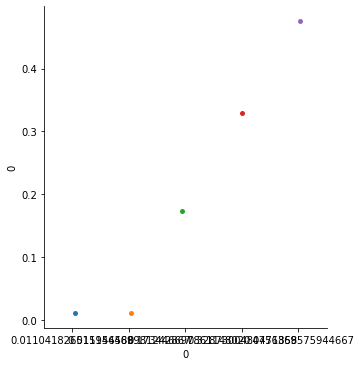

In [45]:
sns.catplot(data=distribution.T, x=0, y=0)

In [46]:
topics.show(25)

+--------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+
|PhraseId|   topicDistribution|               xs[0]|              xs[1]|              xs[2]|               xs[3]|               xs[4]|
+--------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+
|       1|[0.47563695759446...|  0.4756369575944667| 0.3287300480471858|0.17344669786114802|0.011144469981242867|0.011041826515956588|
|       2|[0.03031391953705...|0.030313919537059444| 0.3084434219420343| 0.6103655313283363|0.025547632240896293| 0.02532949495167382|
|       3|[0.61331105738413...|  0.6133110573841334|0.11569384159628339|0.08983182436036083| 0.09083637449822538| 0.09032690216099701|
|       4|[0.0,0.0,0.0,0.0,...|                 0.0|                0.0|                0.0|                 0.0|                 0.0|
|       5|[0.61331105738413...|  0.6133110573841334|0.1

In [47]:
topics = topics.withColumn("prob_max", F.greatest("xs[0]", "xs[1]", "xs[2]", "xs[3]", "xs[4]"))\
                                      .withColumn("prediction", F.when(F.col("prob_max") == F.lit(0.0), F.lit(2))\
                                                                        .when(F.col("prob_max") == F.col("xs[0]"), F.lit(0))\
                                                                        .when(F.col("prob_max") == F.col("xs[1]"), F.lit(1))\
                                                                        .when(F.col("prob_max") == F.col("xs[2]"), F.lit(2))\
                                                                        .when(F.col("prob_max") == F.col("xs[3]"), F.lit(3))\
                                                                        .when(F.col("prob_max") == F.col("xs[4]"), F.lit(4)))
topics.show(25)

+--------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+----------+
|PhraseId|   topicDistribution|               xs[0]|              xs[1]|              xs[2]|               xs[3]|               xs[4]|           prob_max|prediction|
+--------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+----------+
|       1|[0.47563695759446...|  0.4756369575944667| 0.3287300480471858|0.17344669786114802|0.011144469981242867|0.011041826515956588| 0.4756369575944667|         0|
|       2|[0.03031391953705...|0.030313919537059444| 0.3084434219420343| 0.6103655313283363|0.025547632240896293| 0.02532949495167382| 0.6103655313283363|         2|
|       3|[0.61331105738413...|  0.6133110573841334|0.11569384159628339|0.08983182436036083| 0.09083637449822538| 0.09032690216099701| 0.6133110573841334|         0|
|   

In [48]:
print(f"Rows: {topics.select('PhraseId').count()} x Columns {len(topics.columns)}")

Rows: 156060 x Columns 9


In [50]:
sentiments_with_topics = data_df.join(topics, on=["PhraseId"])

In [51]:
sentiments_with_topics.show(10)

+--------+----------+--------------------+---------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+----------+
|PhraseId|SentenceId|              Phrase|Sentiment|   topicDistribution|               xs[0]|              xs[1]|              xs[2]|               xs[3]|               xs[4]|           prob_max|prediction|
+--------+----------+--------------------+---------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+----------+
|       1|         1|A series of escap...|        1|[0.47563695759446...|  0.4756369575944667| 0.3287300480471858|0.17344669786114802|0.011144469981242867|0.011041826515956588| 0.4756369575944667|         0|
|       2|         1|A series of escap...|        2|[0.03031391953705...|0.030313919537059444| 0.3084434219420343| 0.6103655313283363|0.025547632240896293| 0.0253294949

In [68]:
sentiments_with_topics_pdf = sentiments_with_topics.toPandas()

In [58]:
sentiments_with_topics_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PhraseId           156060 non-null  object 
 1   SentenceId         156060 non-null  object 
 2   Phrase             156060 non-null  object 
 3   Sentiment          156060 non-null  object 
 4   topicDistribution  156060 non-null  object 
 5   xs[0]              156060 non-null  float64
 6   xs[1]              156060 non-null  float64
 7   xs[2]              156060 non-null  float64
 8   xs[3]              156060 non-null  float64
 9   xs[4]              156060 non-null  float64
 10  prob_max           156060 non-null  float64
 11  prediction         156060 non-null  int32  
dtypes: float64(6), int32(1), object(5)
memory usage: 13.7+ MB


In [60]:
sentiments_with_topics_pdf["Sentiment"] = sentiments_with_topics_pdf["Sentiment"].astype("int") 

In [61]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [65]:
lda_accuracy = ((sentiments_with_topics_pdf["Sentiment"] == sentiments_with_topics_pdf["prediction"]).sum() / sentiments_with_topics_pdf.shape[0]).round(4)
print(lda_accuracy)

0.1683


In [66]:
def score_model(true_labels, predictions):
    precision = precision_score(true_labels, predictions, average='macro').round(4)
    recall = recall_score(true_labels, predictions, average='macro').round(4)
    f_measure = f1_score(true_labels, predictions, average='macro').round(4)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F Measure: ", f_measure)
    return precision, recall, f_measure

In [67]:
lda_scores = score_model(sentiments_with_topics_pdf["Sentiment"], sentiments_with_topics_pdf["prediction"])

Precision:  0.2035
Recall:  0.2023
F Measure:  0.1384
